
## 1. Task description

You will work on the face recognition and face completion tasks. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel. You should aim at efficient implementation so that this notebook takes no more than 10 minutes to run on lab computers. 

## 2. Preparation

### 2.1 Setting up

The functions that you need are defined in the source file we have provided you with. To use them you need to import it first:

In [1]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces
import numpy as np
import matplotlib.pyplot as plt


Now you can load the data:

In [2]:
data, labels = load_data()

### 2.2 Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

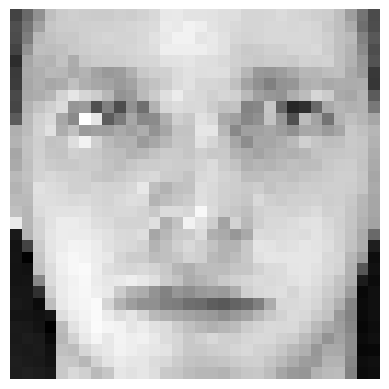

In [3]:
# Display a single example.
show_single_face(data[0, :])

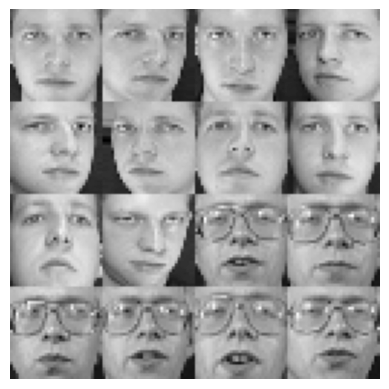

In [4]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[:16, :], num_per_row=4)

### 2.3 Splitting into the train and test sets

First, normalize your pixel values by 1/255 so that the feature values used in later experiments are between $[0,1]$. In general, the normalization trick can make it easier for your to tune parameters in machine learning experiments.

A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. The function takes the labels and the specified number $N$ as the input. And returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [5]:
# normalization
data = data / 255

# partition
train_idx, te_ind = partition_data(labels, num_per_class=3)
train_data = data[train_idx, :]
train_labels = labels[train_idx]
te_data = data[te_ind, :]
test_labels = labels[te_ind]

## 3. $L_2$-regularised Least Squares
### 3.1 Implementation
Now, you need to implement the function `l2_rls_train` below. 

`l2_rls_train` trains a linear model by minimising the $L_2$-regularised sum of squares loss through zeroing the loss gradient. It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ (lambda) as the input, and return the predicted weights. When $\lambda=0$, use a pseudo-inverse to implement the solution.

In [6]:
def l2_rls_train(train_data, train_labels, lmbd=0, multi=False):
    """
    data: type and description of "data"
    labels: type and description of "labels"
    lmbd: type and description of "lmbd"

    Returns: type and description of the returned variable(s).
    """
    
    # This is just to be consistent with the lecture notes.
    X = train_data
    
    if multi:
        # Get one-hot encoding of labels
        Y = np.zeros((train_labels.shape[0], train_labels.max()))
        Y[np.arange(train_labels.shape[0]), train_labels - 1] = 1
    else:
        Y = train_labels
    
        
    # Expand X with a column of ones.
    X_tilde = np.concatenate((np.ones((X.shape[0], 1)), X), axis=-1)
    
    
    if lmbd == 0:
        # Uses the Moore-Penrose pseudo-inverse. Accommodates both over- and underdetermined cases.
        X_tilde_pinv = np.linalg.pinv(X_tilde) 
    else:
        X_tilde_pinv = np.linalg.inv(X_tilde.T @ X_tilde + lmbd * np.eye(X_tilde.shape[1])) @ X_tilde.T        
    # Note: since the data is 400x1024, it has linearly independent rows, not columns. This means that
    # X.T @ X is 1024x1024 and not full rank (singular), while X @ X.T is 400x400 and full rank (invertible).
    # This is fine when we have a hyperparameter, but if not, we need to use np.pinv() to account for this case.
    
    # Compute the coefficient vector.
    w = X_tilde_pinv @ Y
    
    # Return model parameters.
    return w


Now, implement the function `l2_rls_predict` below. It should take the trained weights and your query data as the input, and return the corresponding prediction.

In [7]:
def l2_rls_predict(w, data):
    """
    data: type and description of "data"
    w: type and description of "w"

    Returns: type and description of the returned variable(s).
    """
    
    # Expand X with a column of ones.
    X_tilde = np.concatenate((np.ones((data.shape[0], 1)), data), axis=-1)
    
    # Compute the prediction.  
    predicted_y = X_tilde @ w
        
    return predicted_y

## 4. Face Recognition 

Use your implemented functions to perform multi-class classification to identify the subject in each image, for all 40 subjects.

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. To evaluate, construct a $40\times 40$ classification error matrix (confusion matrix) for test samples. 

Write your code below. 

In [8]:

def hyperparameter_selection(train_idx):
    """
    Finds the best value for lambda using some method of hyperparameter selection.
    
    This particular one uses LOO.
    """
    
    # Set the range of lambdas
    lambdas = np.logspace(-1, 1, num=6, endpoint=False)
    print('Lambdas:', lambdas, sep='\n')
    
    accs = np.zeros((lambdas.shape[0], train_idx.shape[0]))
    
    for j, lmbd in enumerate(lambdas):
        for i in range(train_idx.shape[0]):
            # data partition
            keep_idx = np.delete(train_idx, i)
            train_data =  data[keep_idx]
            
            # Get one-hot encoding of labels
            train_labels = np.zeros((labels[keep_idx].shape[0], labels[keep_idx].max()))
            train_labels[np.arange(labels[keep_idx].shape[0]), labels[keep_idx] - 1] = 1
            
            w = l2_rls_train(train_data, train_labels, lmbd=lmbd)
            # Note: Common mistake from students. Labels start at 1 but indices start at 0. 
            # e.g. should have `pred_labels = rls_predict.argmax + 1`
            accs[j, i] = (l2_rls_predict(w, data[[train_idx[i]]]).argmax() + 1 == labels[train_idx[i]])
    
    print("Accuracies:", accs.mean(axis=-1))
    best_lambda = lambdas[accs.mean(axis=-1).argmax()]
    print("Using lambda:", best_lambda)

    return best_lambda

In [9]:
### Partition into training and test sets by indices
train_idx_1, test_idx_1 = partition_data(labels, 5)

# WARNING: takes ~5 mins to run!
optimal_lmbd = hyperparameter_selection(train_idx_1)

Lambdas:
[0.1        0.21544347 0.46415888 1.         2.15443469 4.64158883]
Accuracies: [0.875 0.89  0.895 0.91  0.915 0.915]
Using lambda: 2.1544346900318834


In [10]:
# Get one-hot encoding of labels
train_labels = np.zeros((labels[train_idx_1].shape[0], labels[train_idx_1].max()))
train_labels[np.arange(labels[train_idx_1].shape[0]), labels[train_idx_1] - 1] = 1
test_labels = np.zeros((labels[test_idx_1].shape[0], labels[test_idx_1].max()))
test_labels[np.arange(labels[test_idx_1].shape[0]), labels[test_idx_1] - 1] = 1

W_1 = l2_rls_train(data[train_idx_1], train_labels, lmbd=optimal_lmbd)

pred_test_1 = l2_rls_predict(W_1, data[test_idx_1]).argmax(axis=-1) + 1

print("Accuracy:", (pred_test_1 == labels[test_idx_1]).mean())

incorrect_labels = []
incorrect_index = []

for i in range(len(test_idx_1)):
    if pred_test_1[i] != labels[test_idx_1][i]:
        incorrect_labels.append(labels[test_idx_1][i])
        incorrect_index.append(i)

print("Incorrect predictions:", incorrect_labels)

Accuracy: 0.975
Incorrect predictions: [1, 5, 13, 22, 26]


 Pick some subjects that are considered the easist to recognise by your classifier, and print the test images from these subjects below.

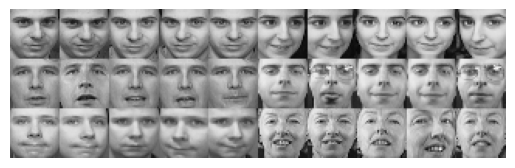

In [11]:

# Watch out for off-by-one errors, labels start at 1 but indices start at 0.
correct_labels = np.delete(np.arange(labels[train_idx_1].max()), np.array(incorrect_labels)-1)+1

# There are many correctly classified, so just show 6 random subjects
rng = np.random.default_rng()
rng.shuffle(correct_labels)
correct_idx = np.where(np.isin(labels[test_idx_1], correct_labels[:6]))[0]
show_faces(data[test_idx_1][correct_idx], num_per_row=10)

 Pick some subjects that are considered the most difficult to recognise by your classifier, and print the misclassified test images from these subjects below.

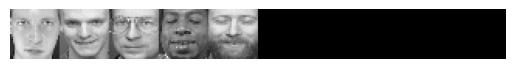

In [12]:
# Your code goes here


show_faces(data[test_idx_1][incorrect_index], num_per_row=10)

## 5. Face Completion 
In this task you will predict the 512 pixels of the right face from the 512 pixels of the left face by formulating a regression task.

The following command can be used to extract the left and right faces from the input data.

In [13]:
left, right = split_left_right(data)

And you can visualise them with the function `show_split_faces()`:

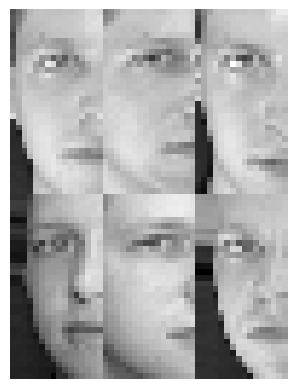

In [14]:
show_split_faces(left[:6, :], num_per_row=3)

Build a face completion model using your regularised least squares model. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error (MAPE) to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below.

In [15]:

train_idx_2, test_idx_2 = partition_data(labels, 5)

# To train, we use the right side of the face as labels for left side input
W_2 = l2_rls_train(left[train_idx_2], right[train_idx_2])
pred_right = l2_rls_predict(W_2, left[test_idx_2])


Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

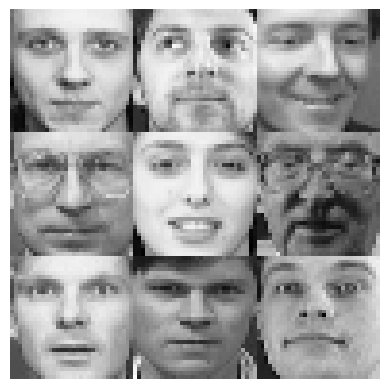

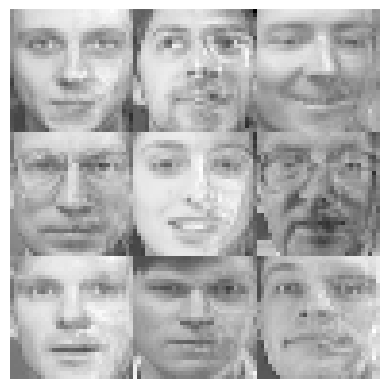

In [16]:

faces = rng.choice(test_idx_2.shape[0], 9, replace=False)
show_faces(join_left_right(left[test_idx_2][faces], right[test_idx_2][faces]), num_per_row=3)
show_faces(join_left_right(left[test_idx_2][faces], pred_right[faces]), num_per_row=3)

Report the MAPE and make some observations regarding the results of the face completion model. 


In [17]:

# MAPE should be around ~23, higher if they used more than 5 images for training.
# An easy suggestion for improvement is to add a regularization term.
print(f"MAPE: {abs((pred_right - right[test_idx_2]) / right[test_idx_2]).mean() * 100:.2f}")

MAPE: 22.41
